In [1]:
#  FROM : https://github.com/dmlc/dgl/tree/master/examples/pytorch/gin
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl
from dgl.data import GINDataset


In [2]:
# dataset = GINDataset(name="IMDBBINARY", self_loop=False)
dataset = GINDataset("MUTAG", self_loop=True)
print(len(dataset))
print("Node feature dimensionality:", dataset.dim_nfeats)
print("Number of graph categories:", dataset.gclasses)
dataset[0][0].ndata["attr"][:5]


188
Node feature dimensionality: 7
Number of graph categories: 2


tensor([[0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1.]])

In [3]:
from sklearn.model_selection import StratifiedKFold
import numpy as np


def split_fold10(labels, fold_idx=0):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    idx_list = []
    for idx in skf.split(np.zeros(len(labels)), labels):
        idx_list.append(idx)
    train_idx, valid_idx = idx_list[fold_idx]
    return train_idx, valid_idx


In [4]:
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler

num_examples = len(dataset)
num_train = int(num_examples * 0.8)

labels = [l for _, l in dataset]
train_idx, val_idx = split_fold10(labels)

train_dataloader = GraphDataLoader(
    dataset, sampler=SubsetRandomSampler(train_idx), batch_size=5, drop_last=False
)
test_dataloader = GraphDataLoader(
    dataset, sampler=SubsetRandomSampler(val_idx), batch_size=5, drop_last=False
)


In [5]:
from dgl.nn import GINConv
from dgl.nn.pytorch.glob import SumPooling, AvgPooling


class MLP(nn.Module):
    """Construct two-layer MLP-type aggreator for GIN model"""

    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.linears = nn.ModuleList()
        # two-layer MLP
        self.linears.append(nn.Linear(input_dim, hidden_dim, bias=False))
        self.linears.append(nn.Linear(hidden_dim, output_dim, bias=False))
        self.batch_norm = nn.BatchNorm1d((hidden_dim))

    def forward(self, x):
        h = x
        h = F.relu(self.batch_norm(self.linears[0](h)))
        return self.linears[1](h)


class GIN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.ginlayers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        num_layers = 5

        # five-layer GCN with two-layer MLP aggregator and sum-neighbor-pooling scheme
        for layer in range(num_layers - 1):  # excluding the input layer
            if layer == 0:
                mlp = MLP(input_dim, hidden_dim, hidden_dim)
            else:
                mlp = MLP(hidden_dim, hidden_dim, hidden_dim)
            self.ginlayers.append(
                GINConv(mlp, learn_eps=False)
            )  # set to True if learning epsilon
            self.batch_norms.append(nn.BatchNorm1d(hidden_dim))
        # linear functions for graph sum poolings of output of each layer
        self.linear_prediction = nn.ModuleList()
        for layer in range(num_layers):
            if layer == 0:
                self.linear_prediction.append(nn.Linear(input_dim, output_dim))
            else:
                self.linear_prediction.append(nn.Linear(hidden_dim, output_dim))
        self.drop = nn.Dropout(0.5)
        self.pool = (
            # SumPooling()
            AvgPooling()
        )  # change to mean readout (AvgPooling) on social network datasets

    def forward(self, g, h):
        # list of hidden representation at each layer (including the input layer)
        hidden_rep = [h]
        for i, layer in enumerate(self.ginlayers):
            h = layer(g, h)
            h = self.batch_norms[i](h)
            h = F.relu(h)
            hidden_rep.append(h)
        score_over_layer = 0
        # perform graph sum pooling over all nodes in each layer
        for i, h in enumerate(hidden_rep):
            pooled_h = self.pool(g, h)
            score_over_layer += self.drop(self.linear_prediction[i](pooled_h))
        return score_over_layer


In [8]:
from tqdm import trange
from numpy import mean
from torch import optim

# Create the model with given dimensions
model = GIN(dataset.dim_nfeats, 16, dataset.gclasses)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

tr = trange(200)
for epoch in tr:
    acc = []

    total = 0
    total_correct = 0
    for batched_graph, labels in train_dataloader:
        logits = model(batched_graph, batched_graph.ndata["attr"].float())
        loss = F.cross_entropy(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total += len(labels)
        total_correct += (logits.argmax(1) == labels).sum().item()
    acc = 1.0 * total_correct / total
    scheduler.step()

    test_acc = []
    for batched_graph, labels in test_dataloader:
        logits = model(batched_graph, batched_graph.ndata["attr"].float())
        total += len(labels)
        total_correct += (logits.argmax(1) == labels).sum().item()
    test_acc = 1.0 * total_correct / total
    tr.set_description(f"acc: {mean(acc):.4f} | test acc {mean(test_acc):.4f}")


  0%|          | 0/200 [00:00<?, ?it/s]/Users/robrossmiller/.venv/ml/lib/python3.9/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (
acc: 0.9231 | test acc 0.9202: 100%|██████████| 200/200 [00:43<00:00,  4.55it/s]


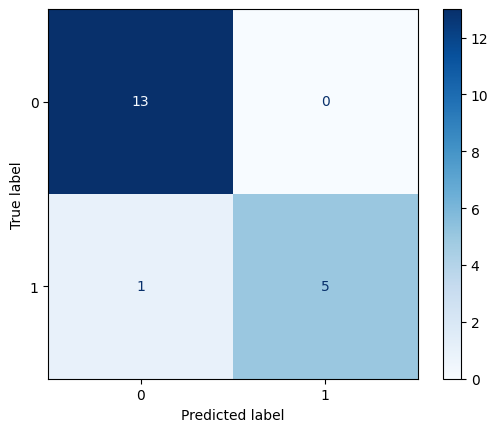

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

l, p = [], []
for batched_graph, labels in test_dataloader:
    pred: torch.Tensor = model(batched_graph, batched_graph.ndata["attr"].float())
    l.extend(labels)
    p.extend(pred.argmax(1))
cm = confusion_matrix(l, p)
cm = ConfusionMatrixDisplay(cm)
cm.plot(cmap="Blues")
